# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

### Problem Statement

In this capstone project, a deep learning model is created which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. Here, we have used Googe Translate text to speech library. 

In [4]:
#Import all the required libraries
# import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from skimage import io
#model building 
# import nltk
# from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow.python.keras import Model
from tqdm import tqdm

%matplotlib inline

In [5]:
print(tf. __version__)

#this project is made using tensorflow version 2.8.2

2.8.2


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [6]:
#Import the dataset and read the image into a seperate variable

images='./flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [7]:
# checking the first 5 entries in all_imgs variable
all_imgs[:5]

['./flickr8k/Images/378453580_21d688748e.jpg',
 './flickr8k/Images/379006645_b9a2886b51.jpg',
 './flickr8k/Images/380034515_4fbdfa6b26.jpg',
 './flickr8k/Images/380041023_0dfd712ef1.jpg',
 './flickr8k/Images/380515798_c2abbf46b0.jpg']

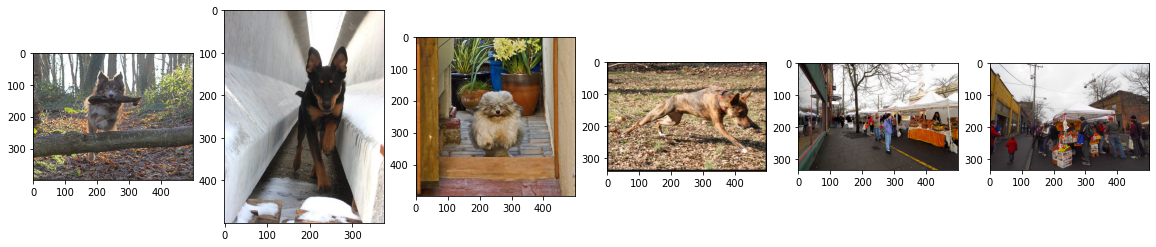

In [8]:
#Visualise both the images & text present in the dataset
# Currently only the images is being visualized as text has not yet been processed.
figure, axes = plt.subplots(1,6)
figure.set_figwidth(20)

#Visualising first 6 images:
for ax,image in zip(axes, all_imgs[0:6]):
    ax.imshow(io.imread(image), cmap=None)

In [9]:
#Import the dataset and read the text file into a seperate variable
text_file = './flickr8k/captions.txt'

def load_doc(filename):
    
    #your code here
    with open(filename, 'r') as ff:
        next(ff) # to skip the header
        text = ff.read()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to


In [10]:
list_of_images_and_captions = []
for i in doc.split('\n'):
    list_of_images_and_captions.append(i.split(",",maxsplit=1)) #to handle captions with comma in them

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [11]:
path_of_images='./flickr8k/Images/'
all_img_id= [img[0] for img in list_of_images_and_captions if img[0]] #store all the image id here
all_img_vector= [path_of_images+img[0] for img in list_of_images_and_captions if img[0]] #store all the image path here
annotations= [img[1] for img in list_of_images_and_captions if img[0]] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,./flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,./flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,./flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,./flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [12]:
df.shape

(40455, 3)

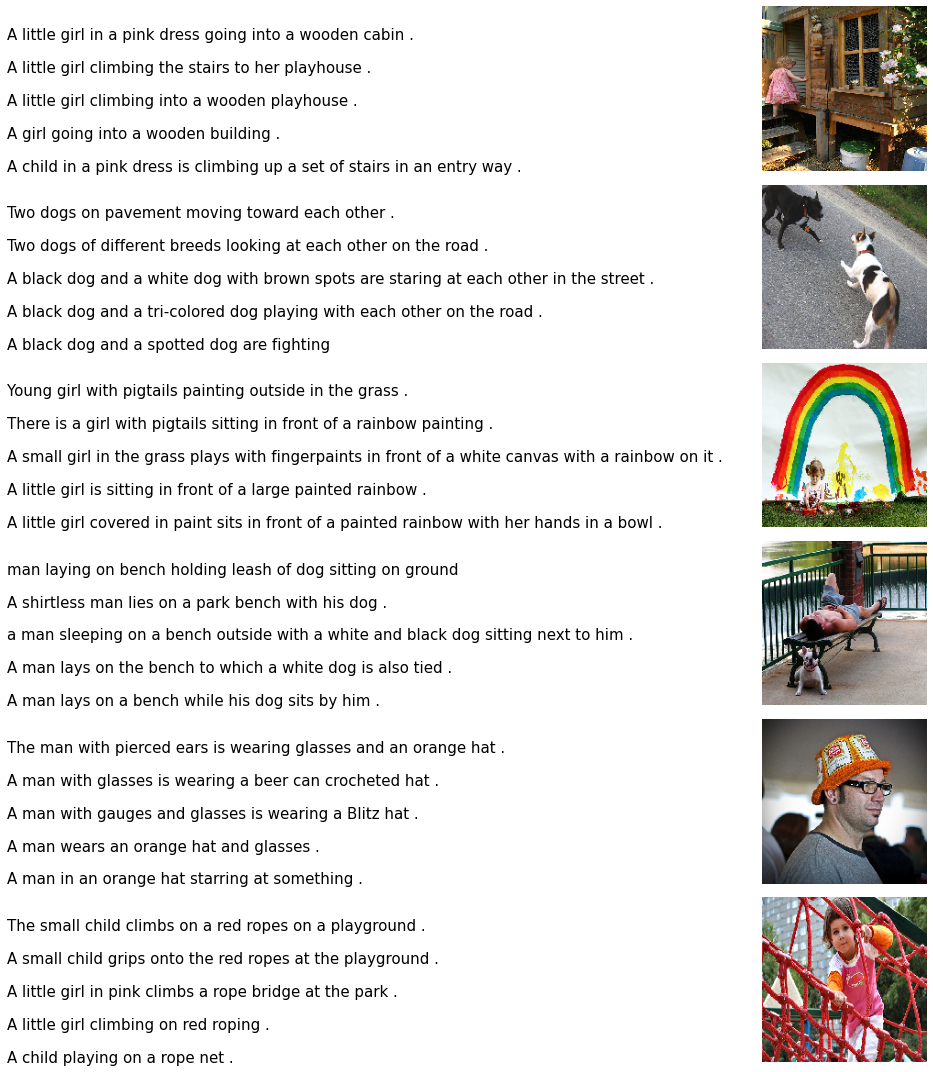

In [13]:
#Visualise both the images & text present in the dataset
fig = plt.figure(figsize=(15,15)) # Setting figsize for proper readability
count = 1
    
for img_path in df[:30].Path.unique(): # selecting the paths of first 6 distinct images
    captions = list(df["Captions"].loc[df.Path == img_path].values)
    display_image = tf.keras.utils.load_img(img_path,target_size=(180,180,3))

    ax = fig.add_subplot(6,2,count) # creating subplots of 6 rows
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  # selecting captions fontsize         
    count+=1
    plt.tight_layout() #to automatically adjust subplot parameters to give specified padding

    ax = fig.add_subplot(6,2,count)
    ax.imshow(display_image)
    plt.axis('off') #since this is a mixed display of photos and captions, we dont require axes
    count +=1

plt.show()

In [14]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations= ['<start> '+ annoted_caption + ' <end>' for annoted_caption in df.Captions] #list which contains all the captions with <start> and <end> tokens added to them.

#Create a list which contains the path to the images
all_img_path= df.Path.unique().tolist() #storing unique paths, as for each image there are 5 captions so 5 duplicate paths are there in the dataframe for each image.

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [15]:
#Create the vocabulary & the counter for the captions
#write your code here
vocabulary= [] # initializing an empty list
for cap in df.Captions.values:
  list_of_words = list(filter(lambda w: len(w)>0, re.split('\W+',cap.lower()))) #this will split at punctuations.
  for word in list_of_words:# for each caption line it will pick out the words contained in them
    vocabulary.append(word)

val_count=Counter(vocabulary) #for counting the ocurrence of each words in the vocabulary list
val_count

Counter({'a': 62992,
         'child': 1545,
         'in': 18986,
         'pink': 739,
         'dress': 348,
         'is': 9345,
         'climbing': 507,
         'up': 1302,
         'set': 109,
         'of': 6723,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 53,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18419,
         'to': 3176,
         'her': 1178,
         'cabin': 4,
         'black': 3848,
         'dog': 8138,
         'and': 8862,
         'spotted': 38,
         'are': 3504,
         'fighting': 133,
         'tri': 14,
         'colored': 221,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10745,
         'road': 398,
         'white': 3959,
         'brown': 2578,
         'spots': 29,
         'staring': 57,
         'at': 2915

In [16]:
#generic function to show the count above seaborn barplot

def show_count(axs, space=.01):
    def _single(ax):
      for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

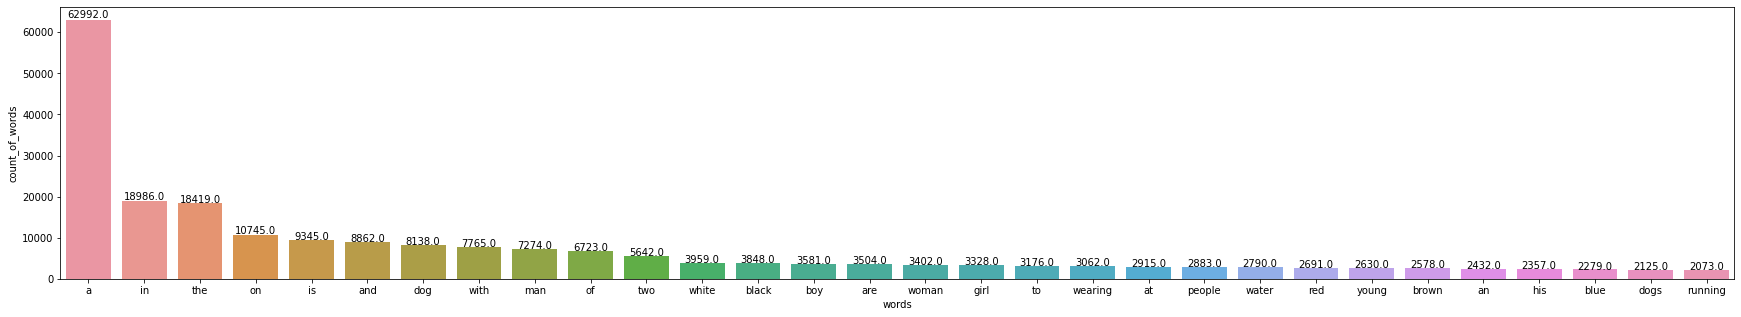

In [17]:
#Visualise the top 30 occuring words in the captions
#write your code here
top30_words_count_df = pd.DataFrame(val_count.most_common(30), columns=['words', 'count_of_words'])
plt.figure(figsize=(30,5))
top30_plot = sns.barplot(x='words', y='count_of_words', data=top30_words_count_df)
show_count(top30_plot)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [18]:
# create the tokenizer
#your code here
max_words = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_words,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="<unk>")# the unknown token used here is <unk>, similar to <start> and <end> tokens.

tokenizer.fit_on_texts(annotations) #updates internal vocab based on a list of text
train_seq = tokenizer.texts_to_sequences(annotations)

In [19]:
# Create word-to-index and index-to-word mappings.

#your code here
# adding PAD token to 0, a reserve index and we can be sure that it isn't assigned to any existing word as such.
tokenizer.word_index['<pad>'] = 0 #updating word index
tokenizer.index_word[0] = '<pad>' #updating index to word

word_to_index_mapping = tokenizer.word_index
index_to_word_mapping = tokenizer.index_word



In [20]:
print(tokenizer.index_word[0]) # re-affirming the pad token

<pad>


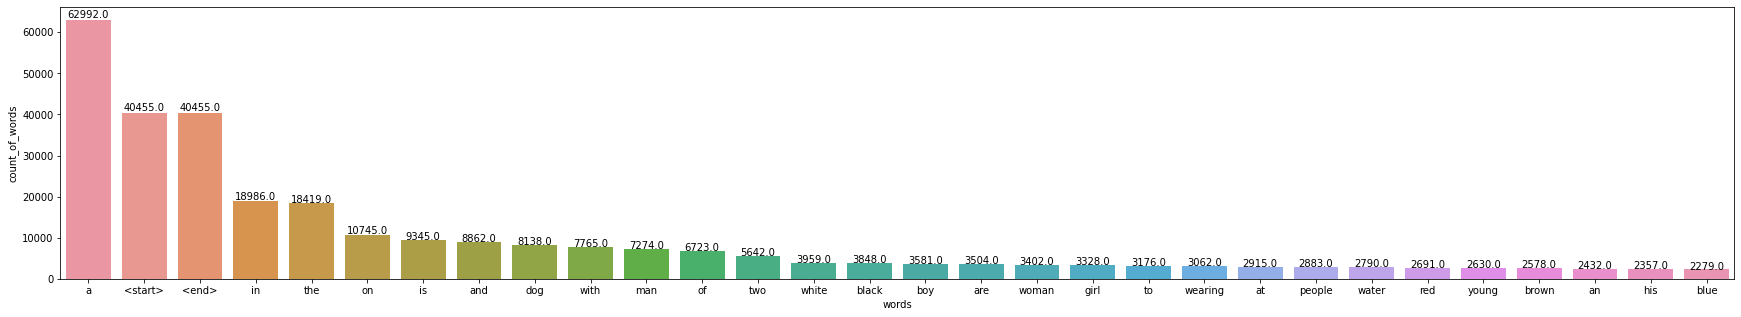

In [22]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here

tokenizer_wc = Counter(tokenizer.word_counts)
top30_tokenizer_wc_df = pd.DataFrame(tokenizer_wc.most_common(30), columns=['words', 'count_of_words'])
plt.figure(figsize=(30,5))
top30_plot = sns.barplot(x='words', y='count_of_words', data=top30_tokenizer_wc_df)
show_count(top30_plot) # plotting the Top 30 occuring words after text processing

In [23]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_seq_len = max([len(x) for x in train_seq]) #calculating the max length of the srquence

# Padding each vector to the max_length of the captions and storing it in cap_vector
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(
    train_seq,
    maxlen=max_seq_len,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0
)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [24]:
# Checking if the above process worked correctly or not.
print(cap_vector[0])
print(annotations[0])

[  3   2  44   5   2  91 173   8 120  52   2 394  13 395   5  29   1 671
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [25]:
#write your code here to create the dataset consisting of image paths

image_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)

In [26]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    image = tf.io.read_file(image_path)
    decoded_image = tf.io.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(decoded_image, (299, 299)) # this will resize the images into the shape of (299,299)
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(resized_image) #among other things it will normalize the image within a range of -1 to 1.
    return preprocessed_image, image_path

In [27]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# we are keeping batch size as 64 and setting drop_remainder to False so not to drop a batch
# if it contains elements less than 64

image_dataset = image_dataset.batch(64,drop_remainder=False)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet') #loading the last layers of pre-trained imagenetV3 model

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

In [29]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# this code here will store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model
image_dict_features={}
for img, img_path in tqdm(image_dataset): # for displaying progress
    img_features = image_features_extract_model(img) # extracting features from images
    img_features_flattened = tf.reshape(img_features,(img_features.shape[0], -1, img_features.shape[3])) #flattening the image to reduce space occupancy
                                   
    for batch_feature, path in zip(img_features_flattened, img_path):
        path_feat = path.numpy().decode("utf-8")
        image_dict_features[path_feat] =  batch_feature.numpy()

100%|██████████| 127/127 [02:17<00:00,  1.08s/it]


## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [30]:
#write your code here
all_img_path= df.Path.tolist() #non-unique paths to images
path_train, path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, test_size=0.2, random_state=101) #splitting into train and test subset for image and captions both

In [31]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [32]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img,cap):
  img_tensor = image_dict_features[img.decode('utf-8')]
  return img_tensor, cap

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [33]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img, cap, batch=64, buffer=1000):
  '''
  gen_dataset(img, cap, batch=64, buffer=1000)
  img = the image path
  cap = cation of the image
  batch: default is 64
  buffer: default is 1000
  '''
  # your code goes here to create the dataset & transform it
  dataset_from_tensor = tf.data.Dataset.from_tensor_slices((img,cap))
  dataset_from_tensor = dataset_from_tensor.map(lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset_from_tensor = dataset_from_tensor.shuffle(buffer)
  dataset_from_tensor = dataset_from_tensor.batch(batch, drop_remainder=False)
  dataset_from_tensor = dataset_from_tensor.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    
  return dataset_from_tensor



In [34]:
train_dataset=gen_dataset(path_train,cap_train)# train dataset generation
test_dataset=gen_dataset(path_test,cap_test)# test dataset generation

In [35]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [36]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // 64 #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // 64 #len(total test images) // BATCH_SIZE
attention_features_shape = batch_feature.shape[0] #attention features shape

### Encoder

In [41]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim,activation='relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape
        
        return features

In [42]:
encoder=Encoder(embedding_dim) #instantiating the encoder

### Attention model

In [44]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expanding the hidden shape 
        score = tf.keras.activations.tanh(self.W1(features)+self.W2(hidden_with_time_axis)) # building the score funciton
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) # extracting the attention weights 
        context_vector = attention_weights*features #creating the context vector
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reducing the shape 
        

        return context_vector, attention_weights

### Decoder

In [45]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') #building the GRU layer
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector,1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size) #instantiating the decoder

In [47]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [48]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) #defining the mask function for the 0s of padding
    loss_ = loss_object(real, pred) #defining the loss function

    mask = tf.cast(mask, dtype=loss_.dtype) #cast the mask tensor to a loss type tensor
    loss_ *= mask #masking the loss function

    return tf.reduce_mean(loss_) #reducing the loss_ tensor.

In [50]:
checkpoint_path = "./checkpoint/" # checkpoint path
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) #to keep the last 5 checkpoint to save space

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [52]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
      #write your code here to do the training steps
      encoded_data = encoder(img_tensor)
      for x in range(1,target.shape[1]):
        pred, hidden, _ = decoder(dec_input, encoded_data, hidden)
        loss += loss_function(target[:, x], pred)
        dec_input = tf.expand_dims(target[:,x], 1)
    avg_loss = (loss/int(target.shape[1])) #avg loss for every batch
    all_trainable_vars = encoder.trainable_variables + decoder.trainable_variables #all trainable variables for which gradient should be calculated
    gradients = tape.gradient(loss,all_trainable_vars) #calculating the new gradients
    optimizer.apply_gradients(zip(gradients, all_trainable_vars))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [53]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_output = encoder(img_tensor)
      for x in range(1,target.shape[1]):
        pred, hidden, _ = decoder(dec_input, encoder_output, hidden)
        loss += loss_function(target[:,x], pred) #updating the loss function
        predicted_id = tf.argmax(pred,1)
        dec_input = tf.expand_dims(predicted_id, 1) #input to decoder, as there is no teacher function

      avg_loss = (loss/int(target.shape[1]))

        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss # updating the total loss
      avg_test_loss = total_loss / train_num_steps
    
    
    return avg_test_loss

In [55]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.282, & test loss is 0.262
Time taken for 1 epoch 166.99729371070862 sec

Test loss has been reduced from 100.000 to 0.262


  7%|▋         | 1/15 [02:47<39:02, 167.35s/it]

For epoch: 2, the train loss is 0.971, & test loss is 0.230
Time taken for 1 epoch 55.76854109764099 sec

Test loss has been reduced from 0.262 to 0.230


 13%|█▎        | 2/15 [03:43<22:04, 101.87s/it]

For epoch: 3, the train loss is 0.876, & test loss is 0.211
Time taken for 1 epoch 55.79783749580383 sec

Test loss has been reduced from 0.230 to 0.211


 20%|██        | 3/15 [04:39<16:11, 80.94s/it] 

For epoch: 4, the train loss is 0.814, & test loss is 0.197
Time taken for 1 epoch 55.743319272994995 sec

Test loss has been reduced from 0.211 to 0.197


 27%|██▋       | 4/15 [05:35<13:02, 71.10s/it]

For epoch: 5, the train loss is 0.764, & test loss is 0.185
Time taken for 1 epoch 55.76918816566467 sec

Test loss has been reduced from 0.197 to 0.185


 33%|███▎      | 5/15 [06:31<10:56, 65.66s/it]

For epoch: 6, the train loss is 0.720, & test loss is 0.175
Time taken for 1 epoch 56.019216775894165 sec

Test loss has been reduced from 0.185 to 0.175


 40%|████      | 6/15 [07:27<09:22, 62.48s/it]

For epoch: 7, the train loss is 0.681, & test loss is 0.165
Time taken for 1 epoch 55.92360067367554 sec

Test loss has been reduced from 0.175 to 0.165


 47%|████▋     | 7/15 [08:23<08:03, 60.42s/it]

For epoch: 8, the train loss is 0.646, & test loss is 0.157
Time taken for 1 epoch 55.80413365364075 sec

Test loss has been reduced from 0.165 to 0.157


 53%|█████▎    | 8/15 [09:19<06:53, 59.03s/it]

For epoch: 9, the train loss is 0.612, & test loss is 0.149
Time taken for 1 epoch 55.80760312080383 sec

Test loss has been reduced from 0.157 to 0.149


 60%|██████    | 9/15 [10:16<05:48, 58.10s/it]

For epoch: 10, the train loss is 0.581, & test loss is 0.141
Time taken for 1 epoch 55.890146255493164 sec

Test loss has been reduced from 0.149 to 0.141


 67%|██████▋   | 10/15 [11:12<04:47, 57.50s/it]

For epoch: 11, the train loss is 0.553, & test loss is 0.134
Time taken for 1 epoch 55.89003849029541 sec

Test loss has been reduced from 0.141 to 0.134


 73%|███████▎  | 11/15 [12:08<03:48, 57.09s/it]

For epoch: 12, the train loss is 0.526, & test loss is 0.128
Time taken for 1 epoch 56.1013662815094 sec

Test loss has been reduced from 0.134 to 0.128


 80%|████████  | 12/15 [13:04<02:50, 56.87s/it]

For epoch: 13, the train loss is 0.501, & test loss is 0.122
Time taken for 1 epoch 55.90158438682556 sec

Test loss has been reduced from 0.128 to 0.122


 87%|████████▋ | 13/15 [14:00<01:53, 56.66s/it]

For epoch: 14, the train loss is 0.478, & test loss is 0.116
Time taken for 1 epoch 55.93884539604187 sec

Test loss has been reduced from 0.122 to 0.116


 93%|█████████▎| 14/15 [14:57<00:56, 56.52s/it]

For epoch: 15, the train loss is 0.458, & test loss is 0.112
Time taken for 1 epoch 55.829413652420044 sec

Test loss has been reduced from 0.116 to 0.112


100%|██████████| 15/15 [15:53<00:00, 63.55s/it]


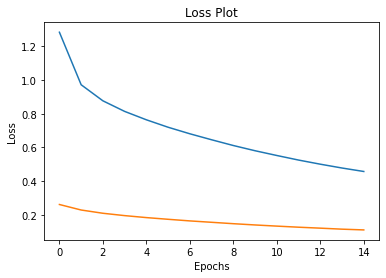

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [57]:
def evaluate(image):
    attention_plot = np.zeros((max_seq_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_seq_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Evaluation on Test set using BLEU score

In [58]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [59]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 51.546695909322914
Real Caption: a black dog lays on a grassy lawn covered in leaves
Prediction Caption: a black dog lays in leaves and leaves


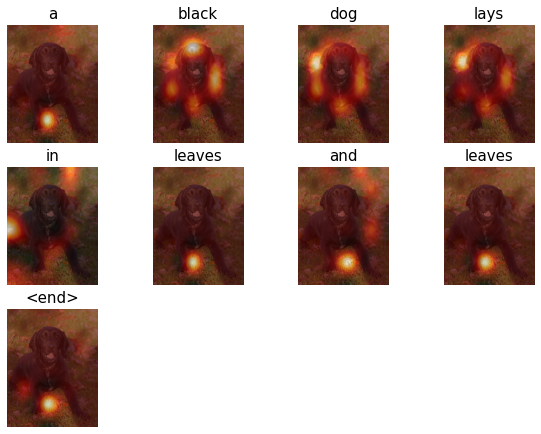

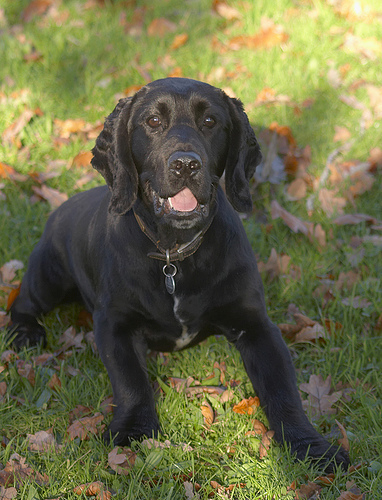

In [60]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))#set your weights
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

BELU score: 84.64817248906141
Real Caption: a man runs on a track outside
Prediction Caption: a man runs on a track


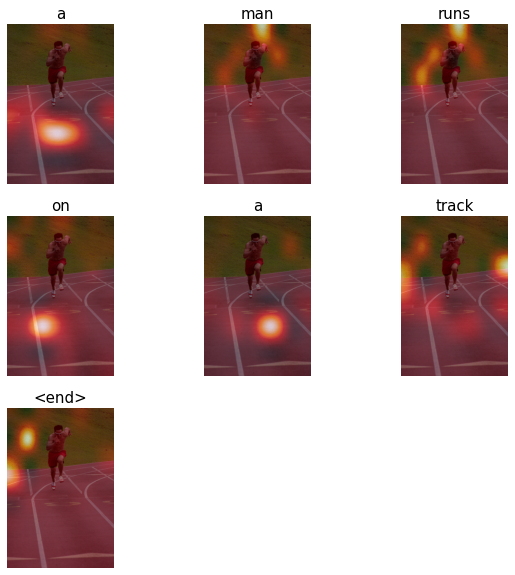

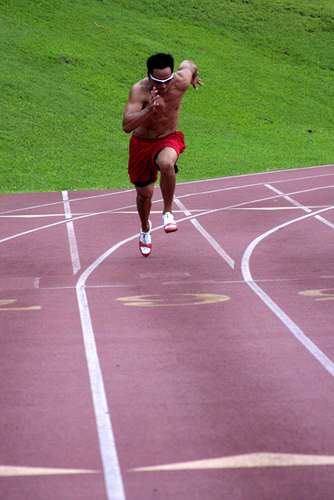

In [63]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))#set your weights
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

### Predictions to Audio conversion

In [64]:
!pip install gTTS #Google Translate text-to-speech API

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Required libraries
from gtts import gTTS
from IPython import display

In [66]:
text_to_audio = gTTS(pred_caption)
text_to_audio.save('prediction_audio.mp3')

In [67]:
display.display(display.Audio('prediction_audio.mp3'))